In [1]:
import numpy as np
import os
import lightkurve as lk
import pandas as pd
import matplotlib.pyplot as plt

from astroquery.mast import Catalogs

from leo_vetter.stellar import quadratic_ldc
from leo_vetter.main import TCELightCurve
from leo_vetter.plots import plot_summary_with_diff, plot_diffimages
from leo_vetter.thresholds import check_thresholds
from leo_vetter.pixel import pixel_vetting

from tess_stars2px import tess_stars2px_function_entry as ts2px

### Vetting example for a False Positive

The previous examples gave nice results for a known planet, which passed all tests (as expected). This example shows the vetter's performance on a false positive, a 2.5-day eclipsing binary orbiting TIC-4292952.

In [2]:
tic = 4292952
per = 2.5443 
epo = 1469.7961
dur = 0.128

# Download light curve
search_result = lk.search_lightcurve(f"TIC {tic}", mission="TESS", author="TESS-SPOC")
lcs = search_result.download_all()
lc = lcs.stitch()
lc = lc[~np.isnan(lc["flux"]) & (lc["quality"] == 0)]
transit_mask = lc.create_transit_mask(transit_time=epo, period=per, duration=dur)
lc_flat = lc.flatten(mask=transit_mask)

time = np.asarray(lc_flat["time"].value)
raw = np.asarray(lc["flux"].value)
flux = np.asarray(lc_flat["flux"].value)
flux_err = np.asarray(lc_flat["flux_err"].value)

# Get stellar properties
result = Catalogs.query_criteria(catalog="TIC", ID=tic)
star = {}
for key in ["rad","mass","rho","Teff","logg"]:
    star[key] = float(result[key])
    star["e_"+key] = float(result["e_"+key])

star["u1"], star["u2"] = quadratic_ldc(star["Teff"], star["logg"])

# Pixel vetting also requires the RA and DEC
star["tic"] = tic
star["ra"] = float(result["ra"])
star["dec"] = float(result["dec"])

# Load the TCELightCurve class
tlc = TCELightCurve(tic, time, raw, flux, flux_err, per, epo, dur, planetno=1)

# Check observed sectors
_, _, _, all_sectors, all_cams, all_ccds, _, _, _ = ts2px(tic, star["ra"], star["dec"])

print(all_sectors, all_cams, all_ccds)

[ 6 32] [1 1] [1 2]


In [3]:
# Flux-level vetting
tlc.compute_flux_metrics(star, verbose=False)

/Users/batfan/miniconda3/envs/exoplanet/lib/python3.12/site-packages/leo_vetter/utils.py:17: RuntimeWarning: invalid value encountered in scalar divide
  mean = np.sum(w * y) / np.sum(w)
/Users/batfan/miniconda3/envs/exoplanet/lib/python3.12/site-packages/leo_vetter/utils.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  err = 1 / np.sqrt(np.sum(w))


Remember that `all_sectors` contains all observed (and yet-to-be-observed) sectors, so adjust accordingly for your specific target. In the case of TIC-4292952, at this time of writing all sectors listed have been observed so we can simply pass that list of sectors to `pixel_vetting`.

In [4]:
# Pixel-level vetting
tdi, good_sectors, good_pixel_data, good_centroids = pixel_vetting(tlc, star, all_sectors)

curl -JL "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=81.3590565087705&dec=-3.66389339703663&y=21&x=21&sector=6" --output ./tic4292952_s6.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100 8657k  100 8657k    0     0  1643k      0  0:00:05  0:00:05 --:--:-- 7495k


['./tic4292952/tess-s0006-1-1_81.359057_-3.663893_21x21_astrocut.fits']
./tic4292952/tess-s0006-1-1_81.359057_-3.663893_21x21_astrocut.fits
Some cadences have an invalid barycentric correction
making difference image for sector 6
curl -JL "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=81.3590565087705&dec=-3.66389339703663&y=21&x=21&sector=32" --output ./tic4292952_s32.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
100 30.5M  100 30.5M    0     0  4203k      0  0:00:07  0:00:07 --:--:-- 10.1M


['./tic4292952/tess-s0032-1-2_81.359057_-3.663893_21x21_astrocut.fits']
./tic4292952/tess-s0032-1-2_81.359057_-3.663893_21x21_astrocut.fits
Some cadences have an invalid barycentric correction
making difference image for sector 32


In [5]:
# Check metrics against the vetting thresholds
print(f"TIC-{tlc.tic}.{tlc.planetno} is offset by {tlc.metrics['offset_qual']:.3f} arcseconds")

FA = check_thresholds(tlc.metrics, "FA", verbose=True)
FP = check_thresholds(tlc.metrics, "FP", verbose=True)

TIC-4292952.1 is offset by 25.523 arcseconds
Passed all FA tests
FP: off-target


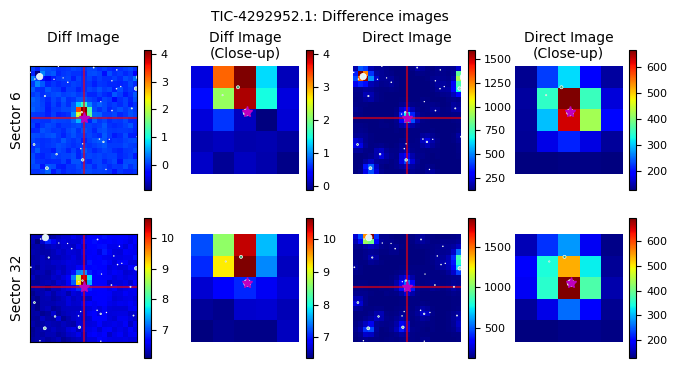

In [6]:
plot_diffimages(tlc.tic, tlc.planetno, tdi, good_sectors, good_pixel_data, save_fig=False)

In [7]:
quality = np.array([centroid["quality"] for centroid in good_centroids])
best_quality_idx = np.argmax(quality)
best_pixel_data = good_pixel_data[best_quality_idx]
print(f"Best difference image is from Sector {good_sectors[best_quality_idx]}")

Best difference image is from Sector 6


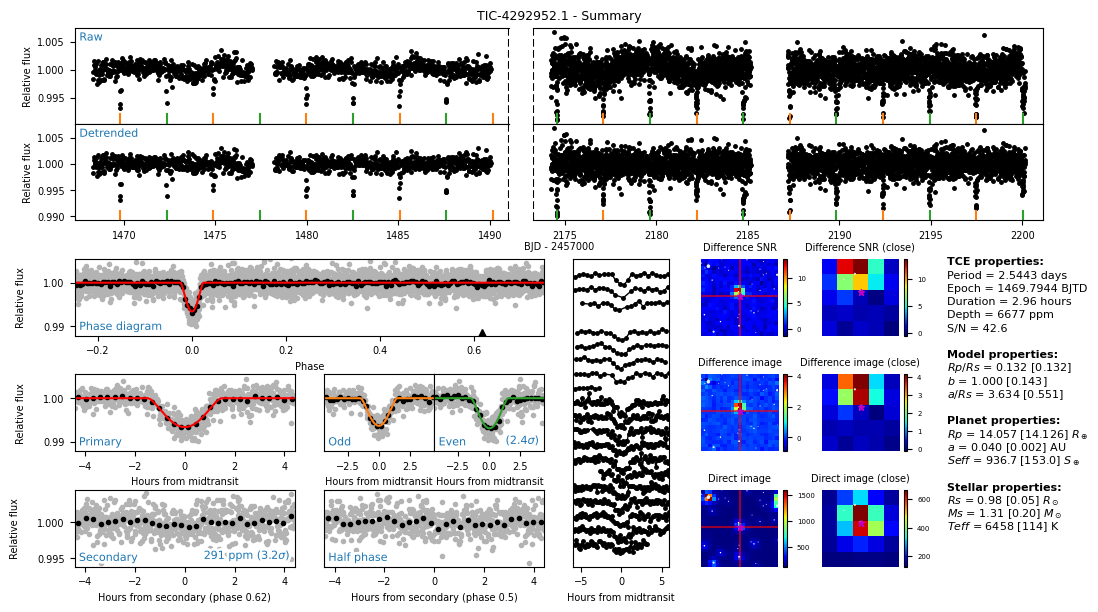

In [8]:
plot_summary_with_diff(tlc, star, tdi, best_pixel_data, save_fig=False)